In [18]:
# If you're on Colab, uncomment:
# %pip -q install torch torchvision torchaudio scikit-learn tqdm pillow matplotlib numpy opencv-python

import random
from pathlib import Path
from dataclasses import dataclass
from typing import List 

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights

# ===== USER CONFIG =====
DATA_DIR = "dataset"          # <--- set this to your dataset root
USE_FLAT_ROOT = True           # True if DATA_DIR has class folders directly (/dataset/drowsy, /dataset/non_drowsy)
MAKE_TEST_SPLIT = True        # Set True if you want to carve out a test split
TEST_SPLIT = 0.2               # Only used if MAKE_TEST_SPLIT=True
VAL_SPLIT = 0.2

IMG_SIZE = 224
ARCH = "resnet18"              # resnet18 | resnet34 | resnet50
BATCH_SIZE = 32                # 32 fits RTX 3050 4GB; on Colab try 128 with resnet50
EPOCHS = 3
LR = 1e-3
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 4
EARLY_STOP_PATIENCE = 5
USE_CLASS_WEIGHTS = False
WARMUP_FREEZE_EPOCHS = 2       # 0 disables warmup (feature extraction phase)
APPLY_FACE_DET = True          # turn off to debug raw pipeline

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM (GB):", round(torch.cuda.get_device_properties(0).total_memory/1e9, 2))


Device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
VRAM (GB): 4.29


In [19]:
def process_img(image_path, output_size=(224, 224), save_path=None):
    """
    Detect face (largest), pad 10%, crop to square, resize to output_size.
    Fallback: center square crop if no face detected.
    Returns PIL.Image (RGB) or None on failure.
    """
    cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    if not Path(cascade_path).exists():
        raise FileNotFoundError(f"Haarcascade not found at {cascade_path}. Install opencv-data.")

    face_cascade = cv2.CascadeClassifier(cascade_path)
    try:
        img = Image.open(image_path).convert('RGB')
        img_np = np.array(img)  # RGB
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            x, y, w, h = max(faces, key=lambda x: x[2] * x[3])  # largest face
            padding = int(max(w, h) * 0.1)
            x = max(0, x - padding)
            y = max(0, y - padding)
            w = min(img_np.shape[1] - x, w + 2 * padding)
            h = min(img_np.shape[0] - y, h + 2 * padding)
            face_crop = img_np[y:y+h, x:x+w]
            processed_img = Image.fromarray(face_crop)
        else:
            # fallback: center square crop
            width, height = img.size
            size = min(width, height)
            left = (width - size) // 2
            top = (height - size) // 2
            processed_img = img.crop((left, top, left + size, top + size))

        processed_img = processed_img.resize(output_size, Image.Resampling.LANCZOS)
        if save_path:
            processed_img.save(save_path, quality=95)
        return processed_img
    except Exception as e:
        print(f"[process_img] Error with {image_path}: {e}")
        return None


In [20]:
def get_transforms(img_size: int = 224):
    # Keep augs modest since face crop standardizes framing; add Jitter/Flip if needed.
    train_tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    val_tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    return train_tfms, val_tfms


In [21]:
def collect_files_flat(root: str):
    root = Path(root)
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    assert len(classes) >= 2, f"Expected at least 2 class folders, found: {classes}"
    files, labels = [], []
    for idx, cls in enumerate(classes):
        for p in (root/cls).rglob("*"):
            if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".webp"}:
                files.append(str(p))
                labels.append(idx)
    return files, labels, classes

def collect_files_train_val(root: str):
    root = Path(root)
    tr = root/"train"; va = root/"val"
    assert tr.exists(), f"{tr} not found"
    files, labels, classes = collect_files_flat(tr)
    if va.exists():
        f2, y2, _ = collect_files_flat(va)
        return (files, labels, classes), (f2, y2, classes), classes
    else:
        return (files, labels, classes), None, classes

class FaceCropDataset(Dataset):
    def __init__(self, filepaths: List[str], labels: List[int], img_size: int, transform, apply_face_det: bool = True):
        self.filepaths = filepaths
        self.labels = labels
        self.img_size = img_size
        self.transform = transform
        self.apply_face_det = apply_face_det

    def __len__(self): return len(self.filepaths)

    def __getitem__(self, idx):
        path = self.filepaths[idx]
        if self.apply_face_det:
            img = process_img(path, output_size=(self.img_size, self.img_size))
            if img is None:
                # fallback: center square crop
                raw = Image.open(path).convert("RGB")
                w, h = raw.size; s = min(w,h)
                left, top = (w-s)//2, (h-s)//2
                img = raw.crop((left, top, left+s, top+s)).resize((self.img_size, self.img_size), Image.Resampling.LANCZOS)
        else:
            raw = Image.open(path).convert("RGB")
            w, h = raw.size; s = min(w,h)
            left, top = (w-s)//2, (h-s)//2
            img = raw.crop((left, top, left+s, top+s)).resize((self.img_size, self.img_size), Image.Resampling.LANCZOS)

        x = self.transform(img)
        y = self.labels[idx]
        return x, y


In [22]:
train_tfms, val_tfms = get_transforms(IMG_SIZE)

if USE_FLAT_ROOT:
    X, y, class_names = collect_files_flat(DATA_DIR)
    print(f"Found {len(X)} images across classes: {class_names}")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=VAL_SPLIT + (TEST_SPLIT if MAKE_TEST_SPLIT else 0.0),
        random_state=SEED, stratify=y
    )
    if MAKE_TEST_SPLIT:
        val_ratio = VAL_SPLIT / (VAL_SPLIT + TEST_SPLIT)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=(1 - val_ratio),
            random_state=SEED, stratify=y_temp
        )
    else:
        X_val, y_val = X_temp, y_temp
        X_test = y_test = None
else:
    (tr_files, tr_labels, class_names), val_bundle, _ = collect_files_train_val(DATA_DIR)
    X_train, y_train = tr_files, tr_labels
    if val_bundle is None:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=VAL_SPLIT, random_state=SEED, stratify=y_train
        )
        X_test = y_test = None
    else:
        X_val, y_val, _ = val_bundle
        X_test = y_test = None

print(f"Train: {len(X_train)} | Val: {len(X_val)}" + (f" | Test: {len(X_test)}" if X_test else ""))

ds_train = FaceCropDataset(X_train, y_train, IMG_SIZE, transform=train_tfms, apply_face_det=APPLY_FACE_DET)
ds_val   = FaceCropDataset(X_val,   y_val,   IMG_SIZE, transform=val_tfms,   apply_face_det=APPLY_FACE_DET)

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

import collections
print("Train class counts:", dict(collections.Counter(y_train)))
print("Val   class counts:", dict(collections.Counter(y_val)))
print("Classes:", class_names)


Found 41793 images across classes: ['drowsy', 'non_drowsy']
Train: 25075 | Val: 8359 | Test: 8359
Train class counts: {0: 13408, 1: 11667}
Val   class counts: {0: 4470, 1: 3889}
Classes: ['drowsy', 'non_drowsy']


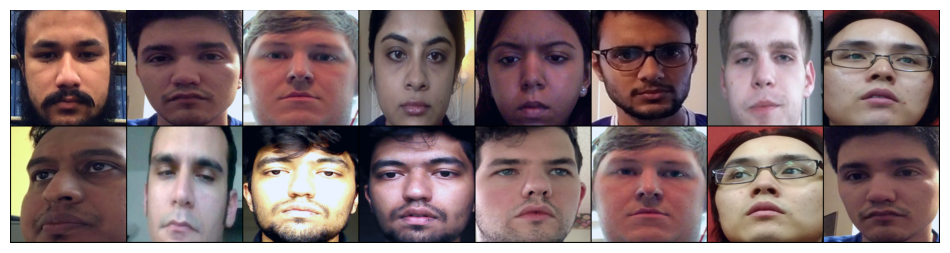

['non_drowsy', 'drowsy', 'non_drowsy', 'non_drowsy', 'non_drowsy', 'non_drowsy', 'drowsy', 'drowsy', 'non_drowsy', 'drowsy', 'drowsy', 'non_drowsy', 'non_drowsy', 'non_drowsy', 'non_drowsy', 'drowsy']


In [23]:
import torchvision
def show_batch(dl, class_names, n=16):
    imgs, labels = next(iter(dl))
    grid = torchvision.utils.make_grid(imgs[:n], nrow=8, normalize=True, scale_each=True)
    plt.figure(figsize=(12,6)); plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.show()
    print([class_names[int(l)] for l in labels[:n]])

show_batch(train_loader, class_names, n=min(16, BATCH_SIZE))


In [24]:
def build_model(arch: str = "resnet18", pretrained: bool = True, num_classes: int = 2) -> nn.Module:
    arch = arch.lower()
    if arch == "resnet18":
        m = models.resnet18(weights=ResNet18_Weights.DEFAULT if pretrained else None)
    elif arch == "resnet34":
        m = models.resnet34(weights=ResNet34_Weights.DEFAULT if pretrained else None)
    elif arch == "resnet50":
        m = models.resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
    else:
        raise ValueError(f"Unsupported arch: {arch}")
    in_features = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, num_classes)
    )
    return m

model = build_model(ARCH, pretrained=True, num_classes=len(class_names)).to(device)
print(f"Model: {ARCH} with {sum(p.numel() for p in model.parameters())/1e6:.2f}M params")


Model: resnet18 with 11.18M params


In [25]:
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train(); running_loss=0.0; correct=0; total=0
    pbar = tqdm(loader, desc="Train", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type=='cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100.0*correct/total)
    return running_loss/total, 100.0*correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval(); running_loss=0.0; correct=0; total=0
    all_y=[]; all_p=[]
    pbar = tqdm(loader, desc="Val", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)
        all_y.extend(y.cpu().numpy().tolist()); all_p.extend(pred.cpu().numpy().tolist())
        pbar.set_postfix(loss=running_loss/total, acc=100.0*correct/total)
    return running_loss/total, 100.0*correct/total, np.array(all_y), np.array(all_p)

def plot_curves(history, outdir: Path):
    outdir.mkdir(parents=True, exist_ok=True)
    plt.figure()
    plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
    plt.savefig(outdir/"loss.png", dpi=200); plt.close()

    plt.figure()
    plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val")
    plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.legend(); plt.tight_layout()
    plt.savefig(outdir/"acc.png", dpi=200); plt.close()

def save_confusion_matrix(y_true, y_pred, class_names: list, outpath: Path):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names, cmap=None)
    plt.tight_layout(); plt.savefig(outpath, dpi=200); plt.close()


In [26]:
# Class weights (optional) — helpful if imbalance
if USE_CLASS_WEIGHTS:
    import collections
    counts = collections.Counter(y_train)
    total = sum(counts.values())
    weights = [total/max(counts[i],1) for i in range(len(class_names))]
    weights = torch.tensor(weights, dtype=torch.float32)
    weights = weights/weights.sum()*len(class_names)
    print("Class weights:", weights.tolist())
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
scaler = GradScaler(enabled=(device.type=='cuda'))


/tmp/ipykernel_19941/3393353503.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type=='cuda'))


In [27]:
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_loss = float("inf"); patience = EARLY_STOP_PATIENCE
best_path = ARTIFACTS_DIR / "best.pt"

def save_best():
    torch.save({"model_state": model.state_dict(),
                "arch": ARCH, "img_size": IMG_SIZE, "class_names": class_names},
               best_path)

# Warmup (feature extraction: train FC head only)
if WARMUP_FREEZE_EPOCHS > 0:
    for name, p in model.named_parameters():
        if not name.startswith("fc."):
            p.requires_grad = False
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=LR, weight_decay=WEIGHT_DECAY)
    print(f"Warmup with frozen backbone for {WARMUP_FREEZE_EPOCHS} epochs...")
    for e in range(1, WARMUP_FREEZE_EPOCHS+1):
        print(f"\nEpoch {e}/{EPOCHS} [WARMUP]")
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        va_loss, va_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device)
        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
        scheduler.step(va_loss)
        if va_loss < best_loss: best_loss=va_loss; save_best(); print("Saved new best.")
        else:
            patience -= 1
            if patience <= 0:
                print("Early stop during warmup.")
                plot_curves(history, ARTIFACTS_DIR)
                save_confusion_matrix(y_true, y_pred, class_names, ARTIFACTS_DIR/"confusion_matrix_val.png")
                raise SystemExit

# Unfreeze & fine-tune full model
for p in model.parameters(): p.requires_grad = True
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=LR, weight_decay=WEIGHT_DECAY)
print("Backbone unfrozen. Fine-tuning...")

for e in range(WARMUP_FREEZE_EPOCHS+1, EPOCHS+1):
    print(f"\nEpoch {e}/{EPOCHS}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
    va_loss, va_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device)
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    scheduler.step(va_loss)

    print(f"Train {tr_loss:.4f}/{tr_acc:.2f}% | Val {va_loss:.4f}/{va_acc:.2f}%")
    if va_loss < best_loss:
        best_loss=va_loss; save_best(); print("Saved new best.")
    else:
        patience -= 1
        if patience <= 0:
            print(f"Early stopping (no val improvement for {EARLY_STOP_PATIENCE} epochs).")
            break

plot_curves(history, ARTIFACTS_DIR)
save_confusion_matrix(y_true, y_pred, class_names, ARTIFACTS_DIR/"confusion_matrix_val.png")
print(f"Artifacts saved to: {ARTIFACTS_DIR.resolve()}")


Warmup with frozen backbone for 2 epochs...

Epoch 1/3 [WARMUP]


Train:   0%|          | 0/784 [00:00<?, ?it/s]/tmp/ipykernel_19941/1824739769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=='cuda')):


Saved new best.

Epoch 2/3 [WARMUP]


Saved new best.
Backbone unfrozen. Fine-tuning...

Epoch 3/3


Train 0.0840/97.95% | Val 0.0181/99.67%
Saved new best.
Artifacts saved to: /home/aditya/Coding/pyt/Project-1/artifacts


In [30]:
from torchvision import transforms as T

@torch.no_grad()
def predict_single_image(image_path: str, model_path: str = None, device=None, show=False):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ckpt_path = model_path or (ARTIFACTS_DIR / "best.pt")
    ckpt = torch.load(ckpt_path, map_location=device)
    arch = ckpt.get("arch", ARCH); img_size = ckpt.get("img_size", IMG_SIZE)
    cls = ckpt.get("class_names", class_names)

    # rebuild same head-only model
    def _build(a, n): 
        a=a.lower()
        if a=="resnet18": m=models.resnet18(weights=None)
        elif a=="resnet34": m=models.resnet34(weights=None)
        elif a=="resnet50": m=models.resnet50(weights=None)
        else: raise ValueError(a)
        in_f=m.fc.in_features; m.fc=nn.Sequential(nn.Dropout(0.2), nn.Linear(in_f, n)); return m

    m = _build(arch, len(cls)).to(device)
    m.load_state_dict(ckpt["model_state"]); m.eval()

    # face crop (or fallback)
    if APPLY_FACE_DET:
        img = process_img(image_path, output_size=(img_size, img_size))
        if img is None:
            raw = Image.open(image_path).convert("RGB")
            w,h = raw.size; s=min(w,h); left,top=(w-s)//2,(h-s)//2
            img = raw.crop((left,top,left+s,top+s)).resize((img_size,img_size), Image.Resampling.LANCZOS)
    else:
        raw = Image.open(image_path).convert("RGB")
        w,h = raw.size; s=min(w,h); left,top=(w-s)//2,(h-s)//2
        img = raw.crop((left,top,left+s,top+s)).resize((img_size,img_size), Image.Resampling.LANCZOS)

    tfm = T.Compose([T.ToTensor(),
                     T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])
    x = tfm(img).unsqueeze(0).to(device)
    logits = m(x); probs = torch.softmax(logits, dim=1).squeeze(0)
    conf, idx = probs.max(dim=0)

    if show:
        plt.figure(figsize=(3,3)); plt.axis("off"); plt.imshow(img)
        plt.title(f"{cls[idx.item()]} ({float(conf):.2f})"); plt.show()

    return {"label": cls[idx.item()], "confidence": float(conf),
            "probs": {cls[i]: float(probs[i]) for i in range(len(cls))}}


              precision    recall  f1-score   support

      drowsy     0.9991    0.9937    0.9964      4470
  non_drowsy     0.9928    0.9990    0.9959      3889

    accuracy                         0.9962      8359
   macro avg     0.9960    0.9964    0.9962      8359
weighted avg     0.9962    0.9962    0.9962      8359



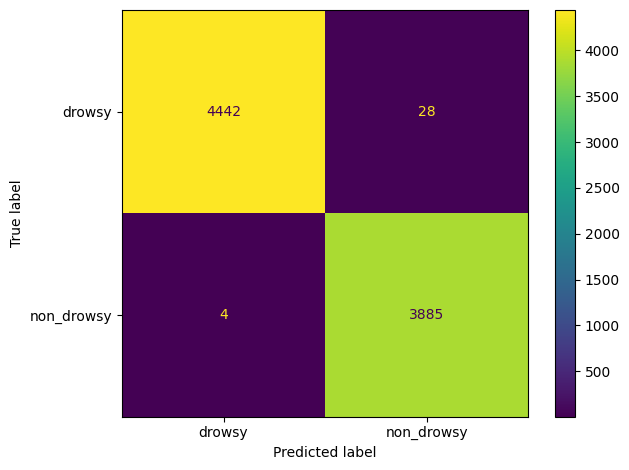

In [31]:
if X_test and y_test:
    ds_test = FaceCropDataset(X_test, y_test, IMG_SIZE, transform=val_tfms, apply_face_det=APPLY_FACE_DET)
    test_loader = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    ckpt = torch.load(ARTIFACTS_DIR / "best.pt", map_location=device)
    cls = ckpt.get("class_names", class_names)
    def _build(a, n): 
        a=a.lower()
        if a=="resnet18": m=models.resnet18(weights=None)
        elif a=="resnet34": m=models.resnet34(weights=None)
        elif a=="resnet50": m=models.resnet50(weights=None)
        else: raise ValueError(a)
        in_f=m.fc.in_features; m.fc=nn.Sequential(nn.Dropout(0.2), nn.Linear(in_f, n)); return m
    m = _build(ckpt.get("arch", ARCH), len(cls)).to(device)
    m.load_state_dict(ckpt["model_state"]); m.eval()
    all_y=[]; all_p=[]
    with torch.no_grad():
        for x,y in test_loader:
            x=x.to(device); logits=m(x); all_p.extend(logits.argmax(1).cpu().numpy().tolist()); all_y.extend(y.numpy().tolist())
    print(classification_report(all_y, all_p, target_names=cls, digits=4))
    disp = ConfusionMatrixDisplay.from_predictions(all_y, all_p, display_labels=cls, cmap=None)
    plt.tight_layout(); plt.show()

In [32]:
from pathlib import Path
import json

def predict_directory(
    folder_path: str,
    model_path: str = None,
    save_json: bool = False,
    show: bool = False
):
    """
    Loop through all images in a directory and run predictions.

    Args:
        folder_path (str): Path to directory containing images
        model_path (str): Path to trained model (default: artifacts/best.pt)
        save_json (bool): Whether to save results to results.json
        show (bool): Whether to display each image and prediction

    Returns:
        List[dict]: Each dict contains file, label, confidence, probs
    """
    folder = Path(folder_path)
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    files = [p for p in folder.rglob("*") if p.suffix.lower() in exts]
    if not files:
        print(f"No image files found under {folder.resolve()}")
        return []

    print(f"Found {len(files)} images. Running predictions...\n")
    results = []

    for i, img_path in enumerate(sorted(files), 1):
        try:
            pred = predict_single_image(str(img_path), model_path=model_path, show=show)
            results.append({
                "file": str(img_path),
                "label": pred["label"],
                "confidence": pred["confidence"],
                "probs": pred["probs"]
            })
            print(f"[{i}/{len(files)}] {img_path.name}: {pred['label']} ({pred['confidence']:.2%})")
        except Exception as e:
            print(f"Error on {img_path.name}: {e}")

    if save_json:
        out_path = ARTIFACTS_DIR / "batch_predictions.json"
        with open(out_path, "w") as f:
            json.dump(results, f, indent=2)
        print(f"\nSaved all results to {out_path.resolve()}")

    return results


Found 3 images. Running predictions...



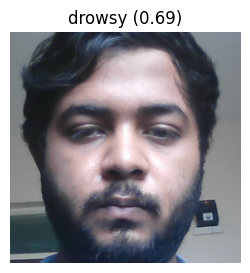

[1/3] 1.jpg: drowsy (69.44%)


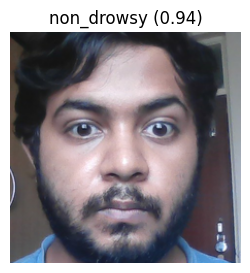

[2/3] 4.jpg: non_drowsy (94.36%)


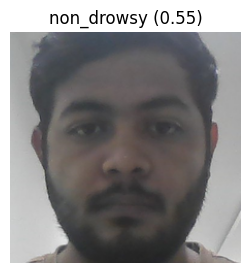

[3/3] 5.jpg: non_drowsy (54.97%)


In [37]:
# Run inference on all images in a folder
results = predict_directory(
    folder_path="test",  # e.g. "/dataset/test/drowsy"
    model_path="artifacts/best.pt",
    save_json=False,
    show=True # set True to visualize each image
)